# Pattern match
### Task: Сделайте self фото на некотором расстоянии от камеры с поднятой рукой. Сделайте crop вашей руки - это ваш шаблон. Исходное изображение - это матрица в которой вы будете искать шаблон.

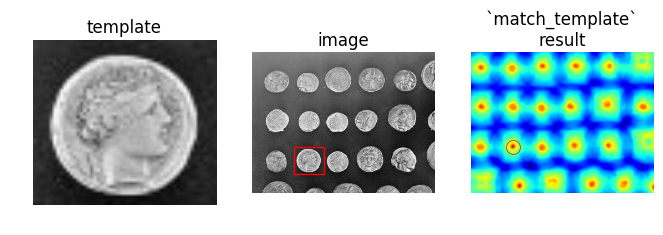

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import match_template


image = data.coins()
coin = image[170:220, 75:130]

result = match_template(image, coin)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, adjustable='box-forced')
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2, adjustable='box-forced')

ax1.imshow(coin, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(image, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hcoin, wcoin = coin.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

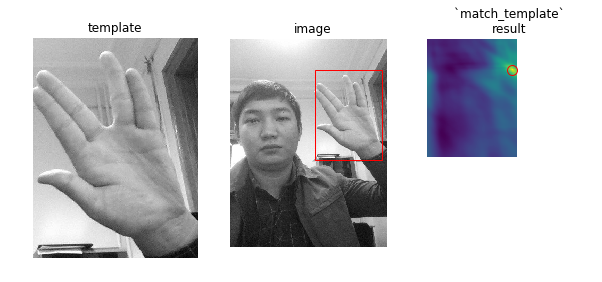

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage import color
import scipy.misc as simg
from skimage.feature import match_template

imMe = simg.imread('./ya.jpg', mode='F')
myHand = imMe[145:560, 390:700]

result = match_template(imMe, myHand)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(10, 50))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2,adjustable='box-forced')
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2, adjustable='box-forced')

ax1.imshow(myHand, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(imMe, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
h, w = myHand.shape
rect = plt.Rectangle((x, y), w, h, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
#ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)


plt.show()

In [ ]:
def hough_transferm(img):
    thetas = np.deg2rad(np.arange(0.0, 180.0))
    width, height = img.shape
    diag_len = np.ceil(np.sqrt(width * width + height * height))   
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2.0)

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)

    H = np.zeros((len(rhos), len(thetas)), dtype=np.int)
    for w in range(width):
        for h in range(height):
            col = img[w, h]
            for t_idx in range(len(thetas)):
                rho = round(w * cos_t[t_idx] - h * sin_t[t_idx])
                H[rho, t_idx] += 1

    return H, thetas, rhos

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import feature
import sys
import math
import pdb

img_orig = cv2.imread('chess.png')
img = img_orig[:,:,::-1] # color channel plotting mess http://stackoverflow.com/a/15074748/2256243

# http://nabinsharma.wordpress.com/2012/12/26/linear-hough-transform-using-python/
def hough_transform(img_bin, theta_res=1, rho_res=1):
    nR,nC = img_bin.shape
    theta = np.linspace(-90.0, 0.0, np.ceil(90.0/theta_res) + 1.0)
    theta = np.concatenate((theta, -theta[len(theta)-2::-1]))

    D = np.sqrt((nR - 1)**2 + (nC - 1)**2)
    q = np.ceil(D/rho_res)
    nrho = 2*q + 1
    rho = np.linspace(-q*rho_res, q*rho_res, nrho)
    H = np.zeros((len(rho), len(theta)))
    for rowIdx in range(nR):
        for colIdx in range(nC):
            if img_bin[rowIdx, colIdx]:
                for thIdx in range(len(theta)):
                    rhoVal = colIdx*np.cos(theta[thIdx]*np.pi/180.0) + \
                    rowIdx*np.sin(theta[thIdx]*np.pi/180)
                    rhoIdx = np.nonzero(np.abs(rho-rhoVal) == np.min(np.abs(rho-rhoVal)))[0]
                    H[rhoIdx[0], thIdx] += 1
    return rho, theta, H

def top_n_rho_theta_pairs(ht_acc_matrix, n, rhos, thetas):
    flat = list(set(np.hstack(ht_acc_matrix)))
    flat_sorted = sorted(flat, key = lambda n: -n)
    coords_sorted = [(np.argwhere(ht_acc_matrix == acc_value)) for acc_value in flat_sorted[0:n]]
    rho_theta = []
    x_y = []
    for coords_for_val_idx in range(0, len(coords_sorted), 1):
        coords_for_val = coords_sorted[coords_for_val_idx]
        for i in range(0, len(coords_for_val), 1):
            n,m = coords_for_val[i] # n by m matrix
            rho = rhos[n]
            theta = thetas[m]
            rho_theta.append([rho, theta])
            x_y.append([m, n]) # just to unnest and reorder coords_sorted
    return [rho_theta[0:n], x_y]

def valid_point(pt, ymax, xmax):
    x, y = pt
    if x <= xmax and x >= 0 and y <= ymax and y >= 0:
        return True
    else:
        return False

def round_tup(tup):
    x,y = [int(round(num)) for num in tup]
    return (x,y)

def draw_rho_theta_pairs(target_im, pairs):
    im_y_max, im_x_max, channels = np.shape(target_im)
    for i in range(0, len(pairs), 1):
        point = pairs[i]
        rho = point[0]
        theta = point[1] * np.pi / 180 # degrees to radians
    # y = mx + b form
        m = -np.cos(theta) / np.sin(theta)
        b = rho / np.sin(theta)
    # possible intersections on image edges
        left = (0, b)
        right = (im_x_max, im_x_max * m + b)
        top = (-b / m, 0)
        bottom = ((im_y_max - b) / m, im_y_max)

        pts = [pt for pt in [left, right, top, bottom] if valid_point(pt, im_y_max, im_x_max)]
        if len(pts) == 2:
            cv2.line(target_im, round_tup(pts[0]), round_tup(pts[1]), (0,0,255), 1)

bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_g = color.rgb2gray(bw)
edges = feature.canny(img_g, sigma=1)
rhos, thetas, H = hough_transform(edges)

rho_theta_pairs, x_y_pairs = top_n_rho_theta_pairs(H, 22, rhos, thetas)
im_w_lines = img.copy()
draw_rho_theta_pairs(im_w_lines, rho_theta_pairs)

# also going to draw circles in the accumulator matrix
for i in range(0, len(x_y_pairs), 1):
    x, y = x_y_pairs[i]
    cv2.circle(img = H, center = (x, y), radius = 12, color=(0,0,0), thickness = 1)

plt.subplot(221),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(edges,cmap = 'gray')
plt.title('Image Edges'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(H)
plt.title('Hough Transform Accumulator'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(im_w_lines)
plt.title('Detected Lines'), plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
# imports
import numpy as np
import cv2
import matplotlib.pyplot as plt


# The Hough Transform is a popular algorithm for detecting any shape that can
# be represented in a parametric mathmatical form in binary images. This
# usually means that images need to be thresholded or filtered prior to running
# the Hough Transform.

# read in shapes image and convert to grayscale
shapes = cv2.imread('ch.png')
#cv2.imshow('Original Image', shapes)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
shapes_grayscale = cv2.cvtColor(shapes, cv2.COLOR_RGB2GRAY)

# blur image (this will help clean up noise for Canny Edge Detection)
shapes_blurred = cv2.GaussianBlur(shapes_grayscale, (5, 5), 1.5)

# find Canny Edges and show resulting image
canny_edges = cv2.Canny(shapes_blurred, 100, 200)
#cv2.imshow('Canny Edges', canny_edges)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
########################################### HOUGH LINES FROM SCRATCH USING NUMPY
# Step 1: The Hough transform needs a binary edges images.  For this particular
# python file, I used the openCV built in Class Canny to create this edge image
# from the original shapes.png file.

# This is the function that will build the Hough Accumulator for the given image
def hough_lines_acc(img, rho_resolution=1, theta_resolution=1):
    ''' A function for creating a Hough Accumulator for lines in an image. '''
    height, width = img.shape # we need heigth and width to calculate the diag
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2)) # a**2 + b**2 = c**2
    rhos = np.arange(-img_diagonal, img_diagonal + 1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))

    # create the empty Hough Accumulator with dimensions equal to the size of
    # rhos and thetas
    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img) # find all edge (nonzero) pixel indexes

    for i in range(len(x_idxs)): # cycle through edge points
        x = x_idxs[i]
        y = y_idxs[i]

        for j in range(len(thetas)): # cycle through thetas and calc rho
            rho = int((x * np.cos(thetas[j]) +
                       y * np.sin(thetas[j])) + img_diagonal)
            H[rho, j] += 1

    return H, rhos, thetas


# This more advance Hough peaks funciton has threshold and nhood_size arguments
# threshold will threshold the peak values to be above this value if supplied,
# where as nhood_size will surpress the surrounding pixels centered around
# the local maximum after that value has been assigned as a peak.  This will
# force the algorithm to look eslwhere after it's already selected a point from
# a 'pocket' of local maxima.
def hough_peaks(H, num_peaks, threshold=0, nhood_size=3):
    ''' A function that returns the indicies of the accumulator array H that
        correspond to a local maxima.  If threshold is active all values less
        than this value will be ignored, if neighborhood_size is greater than
        (1, 1) this number of indicies around the maximum will be surpessed. '''
    # loop through number of peaks to identify
    indicies = []
    H1 = np.copy(H)
    for i in range(num_peaks):
        idx = np.argmax(H1) # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape) # remap to shape of H
        indicies.append(H1_idx)

        # surpess indicies in neighborhood
        idx_y, idx_x = H1_idx # first separate x, y indexes from argmax(H)
        # if idx_x is too close to the edges choose appropriate values
        if (idx_x - (nhood_size/2)) < 0: min_x = 0
        else: min_x = idx_x - (nhood_size/2)
        if ((idx_x + (nhood_size/2) + 1) > H.shape[1]): max_x = H.shape[1]
        else: max_x = idx_x + (nhood_size/2) + 1

        # if idx_y is too close to the edges choose appropriate values
        if (idx_y - (nhood_size/2)) < 0: min_y = 0
        else: min_y = idx_y - (nhood_size/2)
        if ((idx_y + (nhood_size/2) + 1) > H.shape[0]): max_y = H.shape[0]
        else: max_y = idx_y + (nhood_size/2) + 1

        # bound each index by the neighborhood size and set all values to 0
        for x in range(min_x, max_x):
            for y in range(int(min_y), int(max_y)):
                # remove neighborhoods in H1
                H1[y, x] = 0

                # highlight peaks in original H
                if (x == min_x or x == (max_x - 1)):
                    H[y, x] = 255
                if (y == min_y or y == (max_y - 1)):
                    H[y, x] = 255

    # return the indicies and the original Hough space with selected points
    return indicies, H

# drawing the lines from the Hough Accumulatorlines using OpevCV cv2.line
def hough_lines_draw(img, indicies, rhos, thetas):
    ''' A function that takes indicies a rhos table and thetas table and draws
        lines on the input images that correspond to these values. '''
    for i in range(len(indicies)):
        for j in range(len(indicies)):
            # reverse engineer lines from rhos and thetas
            rho = rhos[indicies[i][0]]
            theta = thetas[indicies[i][1]]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            # these are then scaled so that the lines go off the edges of the image
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

# run hough_lines_accumulator on the shapes canny_edges image
H, rhos, thetas = hough_lines_acc(canny_edges)
indicies, H = hough_peaks(H, 14, nhood_size=5) # find peaks
hough_lines_draw(shapes, indicies, rhos, thetas)

# Show image with manual Hough Transform Lines
cv2.imshow('Major Lines: Manual Hough Transform', shapes)
cv2.waitKey(0)
cv2.destroyAllWindows()